## Amazon Fine Food Review - Decision Tree

### 1. Objective

                To find a review whether positive or negative

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import sqlite3
warnings.filterwarnings("ignore")

### 2. Data Cleaning 

In [2]:
#connecting database

con=sqlite3.connect("database.sqlite")

# Read data from database

raw_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",con)

# Removal of Duplicates

pre_data=raw_data.drop_duplicates(['UserId','ProfileName','Time','Text'],keep="first")

# Removal of Unconditioning data (denominator>numerator)

pre_data=pre_data[pre_data.HelpfulnessNumerator<=pre_data.HelpfulnessDenominator]


# Finding NaN values in dataframe

# Reference
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.isnull.html

# Findind NaN values

if pre_data.isnull().values.any() == False:
    print("There is No NaN values in the DataFrame")
else:
    print(" There is NaN values present in the DataFrame")

There is No NaN values in the DataFrame


In [3]:
# sort data based on Time 

filter_data=pre_data.sort_values(by=["Time"],axis=0)

# Class Label changing
# positive class label = 1
# negative class label = 0
a=[]
for i in filter_data["Score"]:
    if i > 3:
        a.append(1)
    else:
        a.append(0)
filter_data["Score"]=a

In [4]:
filter_data.shape

(364171, 10)

In [5]:
filter_data["Score"].value_counts()

1    307061
0     57110
Name: Score, dtype: int64

### 3. Text Preprocessing

* We took the Text column for the further review idendification task, because text is the most important feature compared to other features. 

In [6]:
# References
# https://medium.com/@jorlugaqui/how-to-strip-html-tags-from-a-string-in-python-7cb81a2bbf44
# https://stackoverflow.com/a/40823105/4084039
# https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python/47091490#47091490
# https://stackoverflow.com/questions/18082130/python-regex-to-remove-all-words-which-contains-number/18082370#18082370
# https://stackoverflow.com/questions/5843518/remove-all-special-characters-punctuation-and-spaces-from-string/5843547#5843547
# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://gist.github.com/sebleier/554280
# stemming tutorial: https://www.geeksforgeeks.org/python-stemming-words-with-nltk/
# Lemmatisation tutorial: https://www.geeksforgeeks.org/python-lemmatization-with-nltk/
# NLTK Stemming package list: https://www.nltk.org/api/nltk.stem.html

from nltk.stem.snowball import EnglishStemmer
import re
from tqdm import tqdm
stemmer=EnglishStemmer()

In [7]:
raw_text_data=filter_data["Text"].values

In [8]:
# Stopwords

stopwords= set(['since','br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

# expanding contractions

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [9]:
preprocessed_text_data=[]
for i in tqdm(raw_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alpha_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_text_data.append(b' '.join(k).decode())

100%|█████████████████████████████████████████████████████████████████████████| 364171/364171 [10:32<00:00, 576.03it/s]


In [10]:
filter_data["Text"]=preprocessed_text_data

In [11]:
filter_data.shape

(364171, 10)

In [12]:
filter_data.shape

(364171, 10)

In [13]:
# we took the sample data size as 100k 

final_data=filter_data[:100000]
final_data.shape

(100000, 10)

### 4. Data Splitting

In [14]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [15]:
X=final_data.Text
Y=final_data.Score

In [16]:
x_1,x_test,y_1,y_test=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train,x_cv,y_train,y_cv=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train.shape,y_train.shape)

print("cv data size")
print(x_cv.shape,y_cv.shape)
print("Test data size")
print(x_test.shape,y_test.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


### 5. Featurization

#### 5.1 Bag of Words (BOW)

In [17]:
# Reference
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

from sklearn.feature_extraction.text import CountVectorizer

In [18]:
bow_model=CountVectorizer(ngram_range=(1,2),min_df=5,max_features=500)

# BOW on Train data

bow_train_vec1=bow_model.fit_transform(x_train)

# BOW on cv data

bow_cv_vec1=bow_model.transform(x_cv)

# BOW on Test data

bow_test_vec1=bow_model.transform(x_test)

In [19]:
# the number of words in BOW or Vector size

print("The size of BOW vectorizer")
print(bow_train_vec1.get_shape()[1])

The size of BOW vectorizer
500


#### 5.2 TFIDF

In [20]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

from sklearn.feature_extraction.text import TfidfVectorizer

In [21]:
tfidf_model=TfidfVectorizer(ngram_range=(1,2),min_df=5,max_features=500)

# TFIDF on Train data 

tfidf_train_vec1=tfidf_model.fit_transform(x_train)

# TFIDF on cv data

tfidf_cv_vec1=tfidf_model.transform(x_cv)

# TFIDF on Test data

tfidf_test_vec1=tfidf_model.transform(x_test)

In [22]:
# the number of words in BOW or Vector size

print("The size of TFIDF vectorizer")
print(tfidf_train_vec1.get_shape()[1])

The size of TFIDF vectorizer
500


#### 5.3 W2V

In [23]:
# References
# https://radimrehurek.com/gensim/models/word2vec.html
# https://machinelearningmastery.com/develop-word-embeddings-python-gensim/
# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY

from gensim.models import Word2Vec

In [24]:
list_sentences_train=[]
for i in tqdm(list(x_train)):
    list_sentences_train.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 60000/60000 [00:00<00:00, 123588.04it/s]


In [25]:
word2vec_model=Word2Vec(list_sentences_train,min_count=5,size=50,workers=4)

In [26]:
word2vec_words_train=list(word2vec_model.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train[100:150])

 Number of words
_________________
 
10407
 sample words
_________________
 
['told', 'carri', 'lot', 'use', 'product', 'mani', 'dish', 'marinad', 'flavor', 'beat', 'pungent', 'yet', 'smooth', 'bring', 'meat', 'imagin', 'prefer', 'cold', 'press', 'great', 'way', 'nice', 'abl', 'pour', 'spray', 'bottom', 'line', 'lover', 'beefeat', 'went', 'profit', 'health', 'pet', 'sad', 'pro', 'treat', 'still', 'made', 'usa', 'bottl', 'help', 'tremend', 'adjust', 'daycar', 'pump', 'mother', 'end', 'day', 'babi', 'hungri']


In [27]:
# list of sentences cv data

list_sentences_cv=[]
for i in tqdm(list(x_cv)):
    list_sentences_cv.append(i.split())

# list of sentences test data

list_sentences_test=[]
for i in tqdm(list(x_test)):
    list_sentences_test.append(i.split())

100%|█████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 89549.74it/s]


#### 5.4 Avg W2V

In [28]:
# Reference
# formula of Avg word2vec = sum of all (wi)[i=0 to n]/n

# avg word2vec on training data

avg_word2vec_train=[]
for i in tqdm(list_sentences_train):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_train.append(vector)  
avg_w2v_train=np.asmatrix(avg_word2vec_train)
print("shape of Avg Word2vec train")
print(avg_w2v_train.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:18<00:00, 3180.65it/s]


shape of Avg Word2vec train
(60000, 50)


In [29]:
# avg word2vec on cv data

avg_word2vec_cv=[]
for i in tqdm(list_sentences_cv):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_cv.append(vector)  
avg_w2v_cv=np.asmatrix(avg_word2vec_cv)
print("shape of Avg Word2vec cv")
print(avg_w2v_cv.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:05<00:00, 3782.17it/s]


shape of Avg Word2vec cv
(20000, 50)


In [30]:
# avg word2vec on test data

avg_word2vec_test=[]
for i in tqdm(list_sentences_test):
    vector=np.zeros(50)
    no_of_words=0
    for k in i:
        try:
            w2v_data=word2vec_model.wv[k]
            vector=vector+w2v_data
            no_of_words=no_of_words+1
        except:
            pass
    if no_of_words != 0:
        vector=vector/no_of_words
    avg_word2vec_test.append(vector)  
avg_w2v_test=np.asmatrix(avg_word2vec_test)
print("shape of Avg Word2vec test")
print(avg_w2v_test.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:04<00:00, 4560.29it/s]


shape of Avg Word2vec test
(20000, 50)


#### 5.5 TFIDF W2V

In [31]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model=TfidfVectorizer()
tfidf_w2v_model=model.fit_transform(x_train)
tfidf_w2v=model.get_feature_names()
tfidf_word2vec_train=[]
row=0
for i in tqdm(list_sentences_train):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train.append(vec)
    row=row+1
tfidf_w2v_train=np.asmatrix(tfidf_word2vec_train)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train.shape)

100%|████████████████████████████████████████████████████████████████████████████| 60000/60000 [30:03<00:00, 33.26it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [32]:
# tfidf word2vec on cv data

tfidf_w2v_model=model.transform(x_cv)
tfidf_word2vec_cv=[]
row=0
for i in tqdm(list_sentences_cv):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv.append(vec)
    row=row+1
tfidf_w2v_cv=np.asmatrix(tfidf_word2vec_cv)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:08<00:00, 32.87it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [33]:
# tfidf word2vec on test data

tfidf_w2v_model=model.transform(x_test)
tfidf_word2vec_test=[]
row=0
for i in tqdm(list_sentences_test):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model.wv[w]
            tfidf_freq=tfidf_w2v_model[row,tfidf_w2v.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test.append(vec)
    row=row+1
tfidf_w2v_test=np.asmatrix(tfidf_word2vec_test)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test.shape)

100%|████████████████████████████████████████████████████████████████████████████| 20000/20000 [10:00<00:00, 33.29it/s]


Shape of TFIDF word2vec test
(20000, 50)


### 6. Decision Tree Model

#### 6.1 Creating function for Decision Tree

In [34]:
# References 
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
# ROC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html
# ROC_AUC_CURVE: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html
# AUC_CURVE:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html#sklearn.metrics.auc
# CONFUSION_MATRIX:https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import math

In [139]:
# References for Python Functions:
# https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/function-arguments/
# https://www.geeksforgeeks.org/functions-in-python/
# https://www.geeksforgeeks.org/g-fact-41-multiple-return-values-in-python/

# Fuction for Hyper parameter Tuning

def Decision_Tree(**para):
    
    auc_train=[]
    auc_cv=[]
    
    for i,j in tqdm(zip(para["depth"],para["split_sample"])):
        model=DecisionTreeClassifier(max_depth=i,min_samples_split=j,class_weight='balanced',min_samples_leaf=50)
        model.fit(para["train_vector"],para['train_label'])
        
    # Prediction of training data
    
        train_proba=model.predict_proba(para["train_vector"])
        train=roc_auc_score(para["train_label"],train_proba[:,1])
        auc_train.append(train)
    
    # Prediction of cv data
    
        cv_proba=model.predict_proba(para["cv_vector"])
        cv=roc_auc_score(para["cv_label"],cv_proba[:,1])
        auc_cv.append(cv)
    
    return auc_train,auc_cv

In [140]:
def best_DT (**para):
    
    # Model training

    model=DecisionTreeClassifier(max_depth=para["best_depth"],min_samples_split=para["best_split"],class_weight='balanced',min_samples_leaf=50)
    model.fit(para["train_vector"],para['train_label'])
    
    # training data
    
    DT_train_proba=model.predict_proba(para["train_vector"])
    train_proba=DT_train_proba
    fpr_train,tpr_train,thres_train=roc_curve(para["train_label"],DT_train_proba[:,1])
    auc_train=roc_auc_score(para["train_label"],DT_train_proba[:,1])
    
    # test data
    
    DT_test_proba=model.predict_proba(para["test_vector"])
    test_proba=DT_test_proba
    fpr_test,tpr_test,thres_test=roc_curve(para["test_label"],DT_test_proba[:,1])
    auc_test=roc_auc_score(para["test_label"],DT_test_proba[:,1])
    
    return train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test

In [141]:
# References
# https://pythonprogramming.net/matplotlib-3d-scatterplot-tutorial/

from mpl_toolkits.mplot3d import Axes3D

In [142]:
# References
# https://stackoverflow.com/questions/6282058/writing-numerical-values-on-the-plot-with-matplotlib
#https://matplotlib.org/api/_as_gen/matplotlib.pyplot.annotate.html
# https://pythonprogramming.net/matplotlib-3d-scatterplot-tutorial/

# Fuction for plotting AUC values

def auc_score(**para):
    
    plt.close()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(para["depth"],para["sample"],para["auc_train"], c='b', marker='o',label="AUC of Train data")
    ax.plot(para["depth"],para["sample"],para["auc_cv"],c="r",marker='o',label="AUC of cv data")
    ax.set_xlabel('Depth')
    ax.set_ylabel('Sample')
    ax.set_zlabel('Auc_ score')
    plt.title("Hyperparameter Tuning")
    plt.legend()
    plt.show()

In [143]:
# Fuction for plotting ROC curve

def roc_model(**para):
    plt.close()
    plt.plot(para["fpr_train"],para["tpr_train"],"green",label="ROC curve of Train data,auc="+para['text1'])
    plt.plot(para["fpr_test"],para["tpr_test"],"red",label="ROC curve of Test data,auc="+para['text2'])
    plt.plot([0, 1], [0, 1], color='blue',linestyle='--',label="Center of ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid()
    plt.title("ROC curve")
    plt.legend()
    plt.show()

In [144]:
# References
# confusion matrix of Train and Test data
# https://stackoverflow.com/questions/47264597/confusion-matrix-from-probabilities?rq=1
# plotting confusion matrix: https://seaborn.pydata.org/generated/seaborn.heatmap.html


# Function for confusion matrix

def cm_plot(**para):
    #  confusion matrix of training data
    train_pred_cm=np.argmax(para["train_proba"],axis=1)
    train_confusion_matrix=confusion_matrix(para["train_label"],train_pred_cm,labels=[0,1])
    train_cm=pd.DataFrame(train_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])

    # confusion matrix of test data

    test_pred_cm=np.argmax(para["test_proba"],axis=1)
    test_confusion_matrix=confusion_matrix(para["test_label"],test_pred_cm,labels=[0,1])
    test_cm=pd.DataFrame(test_confusion_matrix,index=["Negative","Positive"],columns=["Negative","Positive"])
    
    plt.close()
    plt.figure(1,figsize=(10,10))
    plt.subplot(211)
    sns.heatmap(train_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Train Data")
    plt.subplot(212)
    sns.heatmap(test_cm,annot=True,fmt='d')
    plt.title("Confusion matrix of Test Data")
    plt.show()

#### 6.2 Decision Tree using BOW

In [170]:
depth=[1,5,10,50,100,500,1000]
sample=[10,50,100,500,1000,1500,2000]

In [171]:
# Hyperparameter tuning

auc_train,auc_cv=Decision_Tree(depth=depth,split_sample=sample,train_vector=bow_train_vec1,train_label=y_train, \
                                             cv_vector=bow_cv_vec1,cv_label=y_cv)

7it [00:12,  1.92s/it]


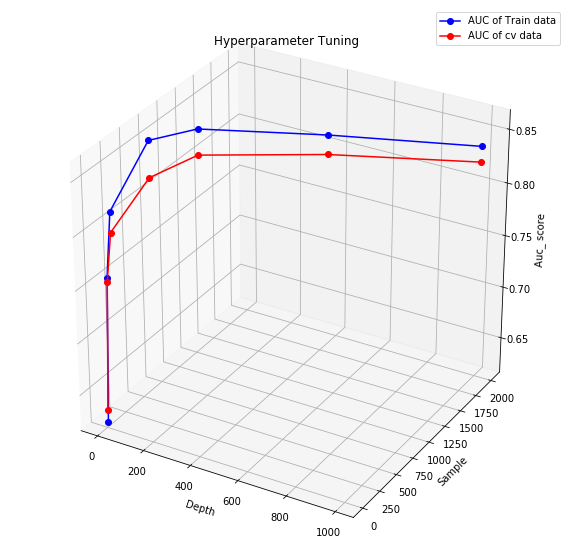

In [172]:
# auc_score plotting

auc_score(depth=depth,sample=sample,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose (depth=50,sample=100), we get auc_score=0.80

In [173]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_DT(best_depth=50,best_split=100,train_vector=bow_train_vec1,train_label=y_train,\
                               test_vector=bow_test_vec1,test_label=y_test)

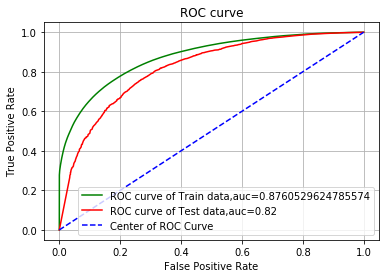

In [174]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

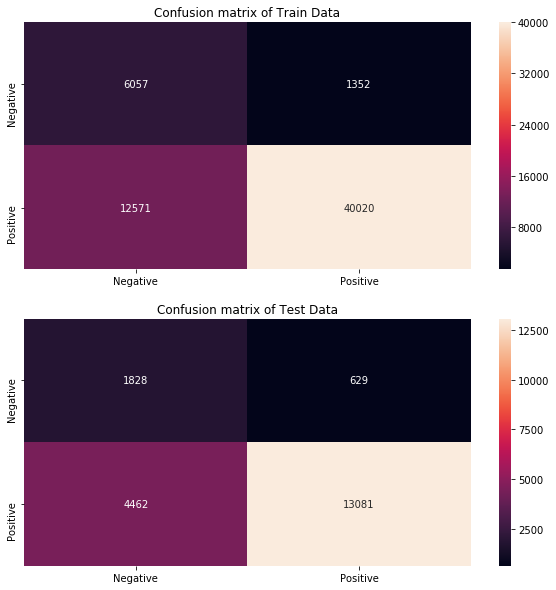

In [175]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (depth = 50, min_samples_split=100) on model, we get auc score of future unseen data is 0.82

#### 6.3 Decision Tree using TFIDF

In [176]:
depth=[1,5,10,50,100,500,1000]
sample=[2,5,10,50,100,500,1000]

In [177]:
# Hyperparameter tuning

auc_train,auc_cv=Decision_Tree(depth=depth,split_sample=sample,train_vector=tfidf_train_vec1,train_label=y_train, \
                                             cv_vector=tfidf_cv_vec1,cv_label=y_cv)

7it [00:37,  5.96s/it]


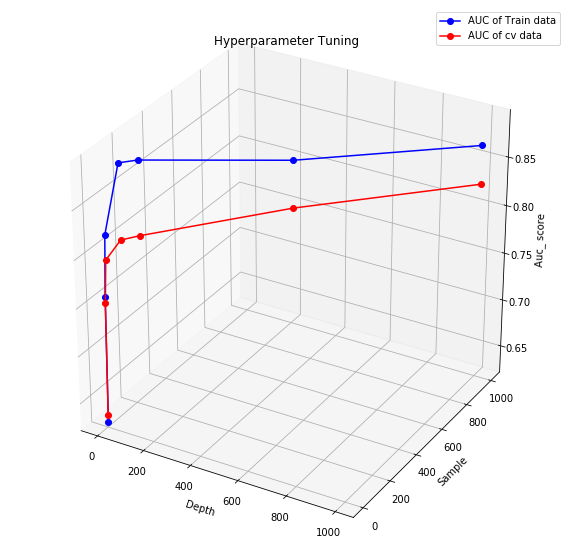

In [178]:
# auc_score plotting

auc_score(depth=depth,sample=sample,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose (depth=50,sample=100), we get auc_score=0.78

In [179]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_DT(best_depth=50,best_split=100,train_vector=tfidf_train_vec1,train_label=y_train,\
                               test_vector=tfidf_test_vec1,test_label=y_test)

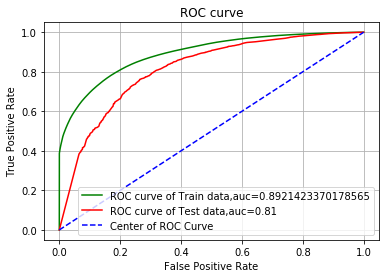

In [180]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

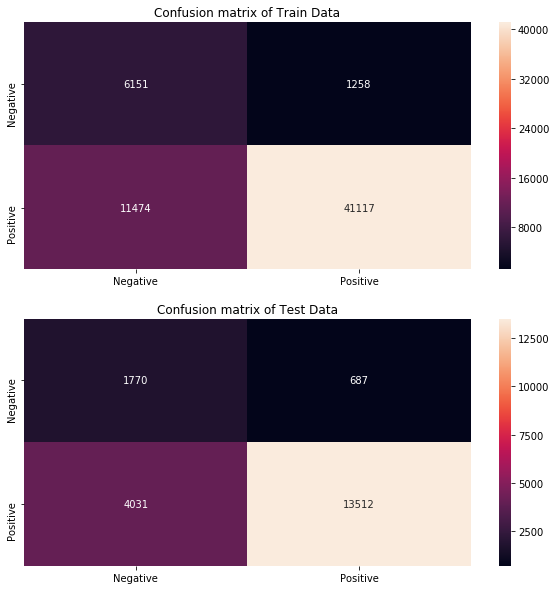

In [181]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (depth = 50 , min_samples_split=100) on model, we get auc score of future unseen data is 0.81

#### 6.4 Decision Tree using Avg W2V

In [182]:
depth=[1,5,10,50,100,500,1000]
sample=[2,5,10,50,100,500,1000]

In [183]:
# Hyperparameter tuning

auc_train,auc_cv=Decision_Tree(depth=depth,split_sample=sample,train_vector=avg_w2v_train,train_label=y_train, \
                                             cv_vector=avg_w2v_cv,cv_label=y_cv)

7it [00:35,  4.92s/it]


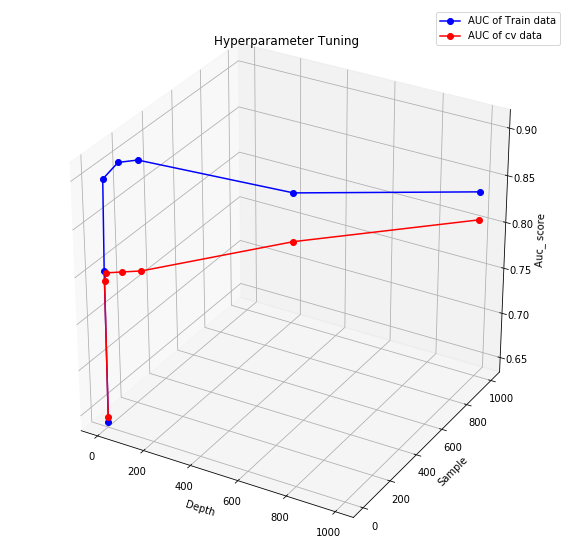

In [184]:
# auc_score plotting

auc_score(depth=depth,sample=sample,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose (depth=50,sample=100), we get auc_score=0.78

In [185]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_DT(best_depth=50,best_split=100,train_vector=avg_w2v_train,train_label=y_train,\
                               test_vector=avg_w2v_test,test_label=y_test)

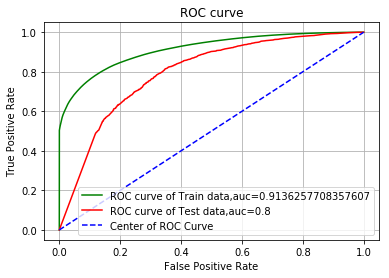

In [186]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

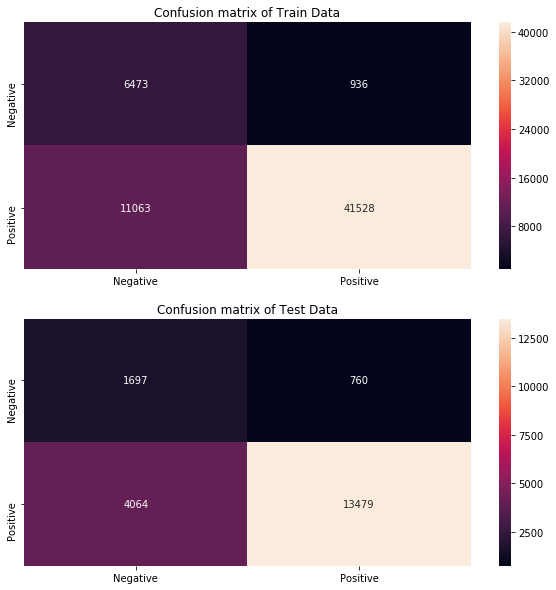

In [187]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (depth = 50 , min_samples_split=100) on model, we get auc score of future unseen data is 0.80

#### 6.5 Decision Tree using TFIDF W2V

In [188]:
depth=[1,5,10,50,100,500,1000]
sample=[2,5,10,50,100,500,1000]

In [189]:
# Hyperparameter tuning

auc_train,auc_cv=Decision_Tree(depth=depth,split_sample=sample,train_vector=tfidf_w2v_train,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv,cv_label=y_cv)

7it [00:30,  4.63s/it]


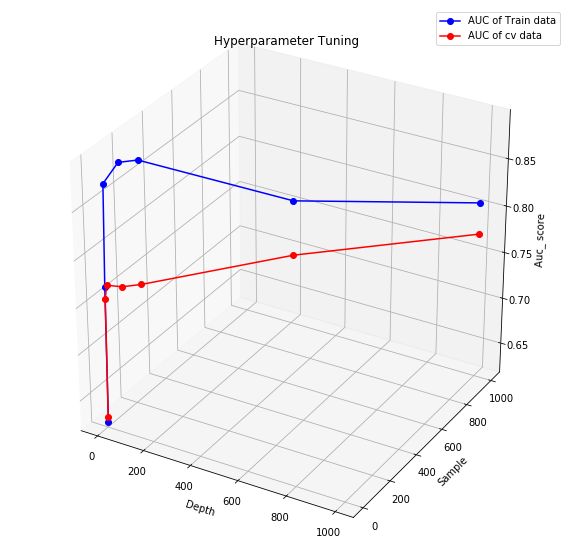

In [190]:
# auc_score plotting

auc_score(depth=depth,sample=sample,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose (depth=50,sample=100), we get auc_score=0.75

In [191]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_DT(best_depth=50,best_split=100,train_vector=tfidf_w2v_train,train_label=y_train,\
                               test_vector=tfidf_w2v_test,test_label=y_test)

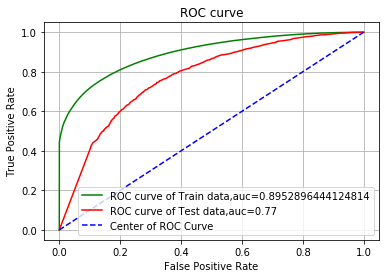

In [192]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

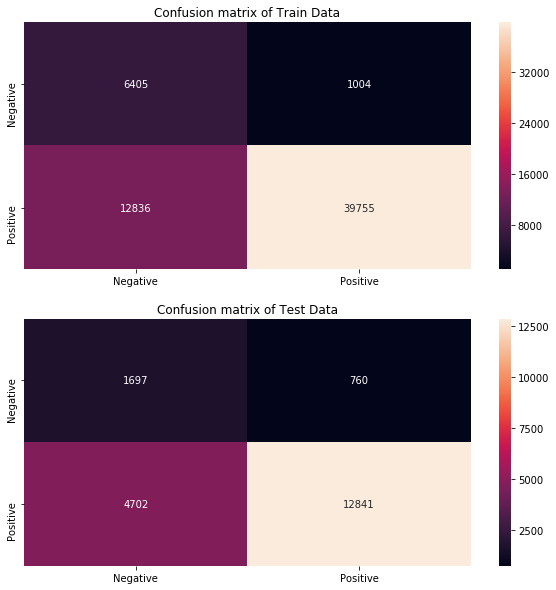

In [193]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (depth = 50 , min_samples_split=100) on model, we get auc score of future unseen data is 0.77

#### 6.6 Model Observations

In [194]:
# References
# http://zetcode.com/python/prettytable/

from prettytable import PrettyTable

In [195]:
x = PrettyTable()

x.field_names = ["Vectorizer","Model", "Max_Depth", "Min_samples_split", "AUC"]

x.add_row(["BOW","Decision Tree",50,100,0.82])
x.add_row(["TFIDF","Decision Tree",50,100,0.81])
x.add_row(["Avg W2V","Decision Tree",50,100,0.80])
x.add_row(["TFIDF W2V","Decision Tree",50,100,0.77])

print(x)

+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
|    BOW     | Decision Tree |     50    |        100        | 0.82 |
|   TFIDF    | Decision Tree |     50    |        100        | 0.81 |
|  Avg W2V   | Decision Tree |     50    |        100        | 0.8  |
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.77 |
+------------+---------------+-----------+-------------------+------+


* Decision Tree using BoW gives Better result compared to other Vectorizers of the Decision Tree Model.

### 7. Visualizing Decision Tree 

#### 7.1 Visualization of Decision Tree BOW Model

In [196]:
# Refernces

# https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html#sklearn-tree-export-graphviz
# https://stackoverflow.com/questions/27817994/visualizing-decision-tree-in-scikit-learn

##### Getting Tree

In [207]:
from sklearn import tree

In [208]:
model=DecisionTreeClassifier(max_depth=50,min_samples_split=100,min_samples_leaf=50,class_weight='balanced')
model.fit(bow_train_vec1,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [209]:
feature=bow_model.get_feature_names()

In [210]:
tree.export_graphviz(model,max_depth=2,out_file="BoW_tree.dot",class_names=['0','1'],feature_names=feature)

##### Decision Tree Image

In [211]:
# References

# https://stackoverflow.com/questions/11854847/how-can-i-display-an-image-from-a-file-in-jupyter-notebook

In [212]:
from IPython.display import Image

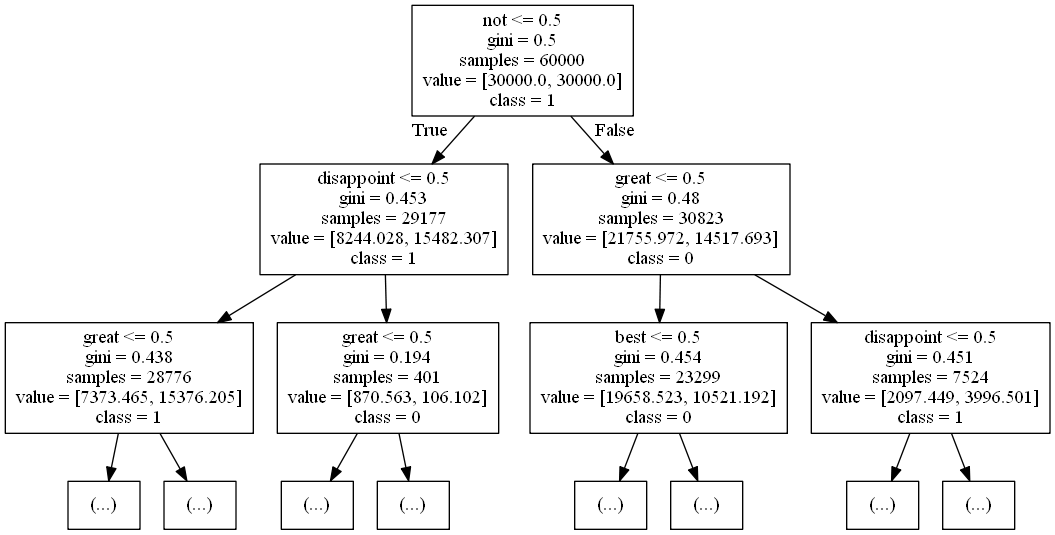

In [217]:
Image(filename="BoW_tree.png")

#### 7.2 Visualization of Decision Tree TFIDF Model

##### Getting Tree

In [213]:
model=DecisionTreeClassifier(max_depth=50,min_samples_split=100,min_samples_leaf=50,class_weight='balanced')
model.fit(tfidf_train_vec1,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [214]:
feature1=tfidf_model.get_feature_names()

In [215]:
tree.export_graphviz(model,max_depth=2,out_file="Tfidf_tree.dot",class_names=['0','1'],feature_names=feature1)

##### Decision Tree Image

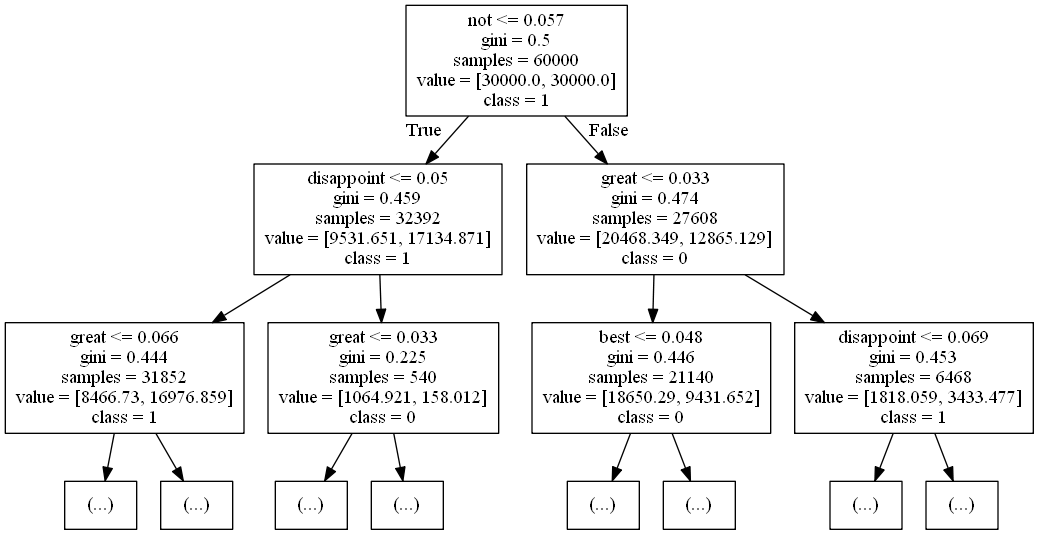

In [216]:
Image(filename="Tfidf_tree.png")

### 8. Feature Importance

#### 8.1 Feature Importance on BOW

In [218]:
model=DecisionTreeClassifier(max_depth=50,min_samples_split=100,min_samples_leaf=50,class_weight='balanced')
model.fit(bow_train_vec1,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [219]:
fi=model.feature_importances_

In [220]:
fi=np.argsort(fi)[::-1]

In [223]:
important_features=np.take(bow_model.get_feature_names(),fi[0:20])

In [224]:
print("Top 20 Important Features of Decision Tree (BOW)")
print("="*125)
print(important_features)

Top 20 Important Features of Decision Tree (BOW)
['not' 'great' 'best' 'disappoint' 'love' 'delici' 'good' 'perfect'
 'favorit' 'high recommend' 'would' 'excel' 'nice' 'tast' 'product' 'bad'
 'tasti' 'use' 'find' 'wonder']


#### 8.2 Feature Importance on TFIDF

In [225]:
model=DecisionTreeClassifier(max_depth=50,min_samples_split=100,min_samples_leaf=50,class_weight='balanced')
model.fit(tfidf_train_vec1,y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='gini',
            max_depth=50, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=50, min_samples_split=100,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [226]:
fi=model.feature_importances_

In [227]:
fi=np.argsort(fi)[::-1]

In [228]:
important_features=np.take(tfidf_model.get_feature_names(),fi[0:20])

In [229]:
print("Top 20 Important Features of Decision Tree (TFIDF)")
print("="*125)
print(important_features)

Top 20 Important Features of Decision Tree (TFIDF)
['not' 'great' 'disappoint' 'best' 'love' 'delici' 'good' 'perfect' 'tast'
 'favorit' 'nice' 'would' 'excel' 'product' 'high recommend' 'use'
 'wonder' 'like' 'tasti' 'bad']


### 9. Feature Engineering

* We do feature engineering on Decision Tree using TFIDF-W2V. Because this gives slightly less performance result compared to others.

#### 9.1 Adding Summary Text as a Feature with Review Text

* We consider summary text as a feature,we do preprocessing and featurization on the summary text and then we horizontally stack the summary text to the review text. so finally we get the extra word vector to improve our model.

##### 9.1.1 Summary Text Preprocessing

In [230]:
raw_summary_text_data=filter_data.Summary.values

In [231]:
# Preprocessing 

preprocessed_summary_text_data=[]
for i in tqdm(raw_summary_text_data):
# removing of HTML tags
    a=re.sub("<.*?>"," ",i)
# removing url
    b=re.sub(r"http\S+"," ",a)
# expanding contractions
    c=decontracted(b)
# removing alphA_numeric
    d=re.sub("\S*\d\S*", " ",c)
# removing Special characters
    e=re.sub('[^A-Za-z0-9]+', ' ',d)
# removing stopwords
    k=[]
    for w in e.split():
        if w.lower() not in stopwords:
            s=(stemmer.stem(w.lower())).encode('utf8')
            k.append(s)
    preprocessed_summary_text_data.append(b' '.join(k).decode())

100%|████████████████████████████████████████████████████████████████████████| 364171/364171 [00:54<00:00, 6707.30it/s]


In [232]:
filter_data["Summary"]=preprocessed_summary_text_data

In [233]:
filter_data.shape

(364171, 10)

In [234]:
# we took the sample data size as 100k 

final_data=filter_data[:100000]
final_data.shape

(100000, 10)

##### 9.1.2. Data Splitting

In [235]:
# References
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

from sklearn.model_selection import train_test_split

In [236]:
X=final_data.Summary
Y=final_data.Score

In [237]:
x_1,x_test_2,y_1,y_test_2=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train_2,x_cv_2,y_train_2,y_cv_2=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train_2.shape,y_train_2.shape)

print("cv data size")
print(x_cv_2.shape,y_cv_2.shape)
print("Test data size")
print(x_test_2.shape,y_test_2.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


##### 9.1.3. Featurization

In [238]:
list_sentences_train_2=[]
for i in tqdm(list(x_train_2)):
    list_sentences_train_2.append(i.split())

100%|█████████████████████████████████████████████████████████████████████████| 60000/60000 [00:01<00:00, 54178.11it/s]


In [239]:
word2vec_model_fe=Word2Vec(list_sentences_train_2,min_count=5,size=50,workers=4)

In [240]:
word2vec_words_train_2=list(word2vec_model_fe.wv.vocab)
print(" Number of words")
print("_________________")
print(" ")
print(len(word2vec_words_train_2))
print("="*125)
print(" sample words")
print("_________________")
print(" ")
print(word2vec_words_train_2[100:150])

 Number of words
_________________
 
2757
 sample words
_________________
 
['strong', 'yummmmmm', 'nectar', 'nice', 'select', 'confus', 'keurig', 'organ', 'black', 'cherri', 'concentr', 'must', 'work', 'food', 'make', 'go', 'yeah', 'move', 'rice', 'krispi', 'treat', 'barbequ', 'chip', 'green', 'bowl', 'edibl', 'pet', 'health', 'risk', 'get', 'unexpect', 'guest', 'super', 'deal', 'anyon', 'need', 'gluten', 'favorit', 'no', 'raspberri', 'celesti', 'season', 'garden', 'refresh', 'tasti', 'light', 'kiwi', 'low', 'caffein', 'hand']


In [241]:
# list of sentences cv data

list_sentences_cv_2=[]
for i in tqdm(list(x_cv_2)):
    list_sentences_cv_2.append(i.split())

# list of sentences test data

list_sentences_test_2=[]
for i in tqdm(list(x_test_2)):
    list_sentences_test_2.append(i.split())

100%|████████████████████████████████████████████████████████████████████████| 20000/20000 [00:00<00:00, 425573.55it/s]


In [242]:
# References
# https://stackoverflow.com/questions/21553327
# https://github.com/devBOX03


# tfidf word2vec on training data

model_2=TfidfVectorizer()
tfidf_w2v_model_2=model_2.fit_transform(x_train_2)
tfidf_w2v_2=model_2.get_feature_names()
tfidf_word2vec_train_2=[]
row=0
for i in tqdm(list_sentences_train_2):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model_2[row,tfidf_w2v_2.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_train_2.append(vec)
    row=row+1
tfidf_w2v_train_2=np.asmatrix(tfidf_word2vec_train_2)
print("Shape of TFIDF word2vec train")
print(tfidf_w2v_train_2.shape)

100%|██████████████████████████████████████████████████████████████████████████| 60000/60000 [00:56<00:00, 1055.54it/s]


Shape of TFIDF word2vec train
(60000, 50)


In [243]:
# tfidf word2vec on cv data

tfidf_w2v_model_2=model_2.transform(x_cv_2)
tfidf_word2vec_cv_2=[]
row=0
for i in tqdm(list_sentences_cv_2):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model_2[row,tfidf_w2v_2.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_cv_2.append(vec)
    row=row+1
tfidf_w2v_cv_2=np.asmatrix(tfidf_word2vec_cv_2)
print("Shape of TFIDF word2vec cv")
print(tfidf_w2v_cv_2.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1548.83it/s]


Shape of TFIDF word2vec cv
(20000, 50)


In [244]:
# tfidf word2vec on test data

tfidf_w2v_model_2=model_2.transform(x_test_2)
tfidf_word2vec_test_2=[]
row=0
for i in tqdm(list_sentences_test_2):
    vec=np.zeros(50)
    weight_sum=0
    for w in i:
        try:
            w2v_freq=word2vec_model_fe.wv[w]
            tfidf_freq=tfidf_w2v_model_2[row,tfidf_w2v_2.index(w)]
            vec=vec+(w2v_freq*tfidf_freq)
            weight_sum=weight_sum+tfidf_freq
        except:
            pass
    vec=vec/weight_sum
    tfidf_word2vec_test_2.append(vec)
    row=row+1
tfidf_w2v_test_2=np.asmatrix(tfidf_word2vec_test_2)
print("Shape of TFIDF word2vec test")
print(tfidf_w2v_test_2.shape)

100%|██████████████████████████████████████████████████████████████████████████| 20000/20000 [00:12<00:00, 1579.56it/s]


Shape of TFIDF word2vec test
(20000, 50)


##### 9.1.4 Horizontally stacking

In [245]:
# References
# https://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html

In [246]:
# For training data

tfidf_w2v_train_fe=np.hstack((tfidf_w2v_train,tfidf_w2v_train_2))

# For cv data

tfidf_w2v_cv_fe=np.hstack((tfidf_w2v_cv,tfidf_w2v_cv_2))

# For test data

tfidf_w2v_test_fe=np.hstack((tfidf_w2v_test,tfidf_w2v_test_2))

In [247]:
print(tfidf_w2v_train_fe.shape)
print(tfidf_w2v_cv_fe.shape)
print(tfidf_w2v_test_fe.shape)

(60000, 100)
(20000, 100)
(20000, 100)


##### 9.1.5 Feature Engineering on Decision Tree (TFIDF-W2V)

##### 9.1.5.1 Finding best Depth Hyperparameter

In [250]:
depth=[1,5,10,50,100,500,1000]
sample=[2,5,10,50,100,500,1000]

In [251]:
# To eliminate NaN values produced in the TFIDF W2V vectorizer
# https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html
# https://stackoverflow.com/questions/44727793/imputer-mean-strategy-removes-nan-instead-of-replacing

from sklearn.impute import SimpleImputer

In [252]:
imp=SimpleImputer(missing_values=np.nan,strategy='mean')
tfidf_w2v_train_fe_im=imp.fit_transform(tfidf_w2v_train_fe)
tfidf_w2v_cv_fe_im=imp.fit_transform(tfidf_w2v_cv_fe)
tfidf_w2v_test_fe_im=imp.fit_transform(tfidf_w2v_test_fe)

In [253]:
# Hyperparameter tuning

auc_train,auc_cv=Decision_Tree(depth=depth,split_sample=sample,train_vector=tfidf_w2v_train_fe_im,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_fe_im,cv_label=y_cv)

7it [01:09, 10.03s/it]


In [1]:
# auc_score plotting

auc_score(depth=depth,sample=sample,auc_train=auc_train,auc_cv=auc_cv)

NameError: name 'auc_score' is not defined

##### Observation:

* To avoid overfitting and underfitting,choose (depth=50,sample=100), we get auc_score=0.82

In [255]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_DT(best_depth=50,best_split=100,train_vector=tfidf_w2v_train_fe_im,train_label=y_train_2,\
                               test_vector=tfidf_w2v_test_fe_im,test_label=y_test_2)

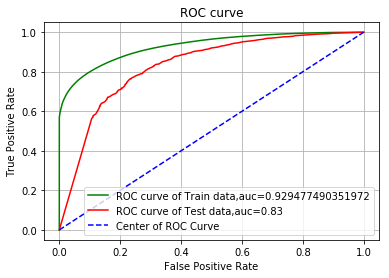

In [256]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

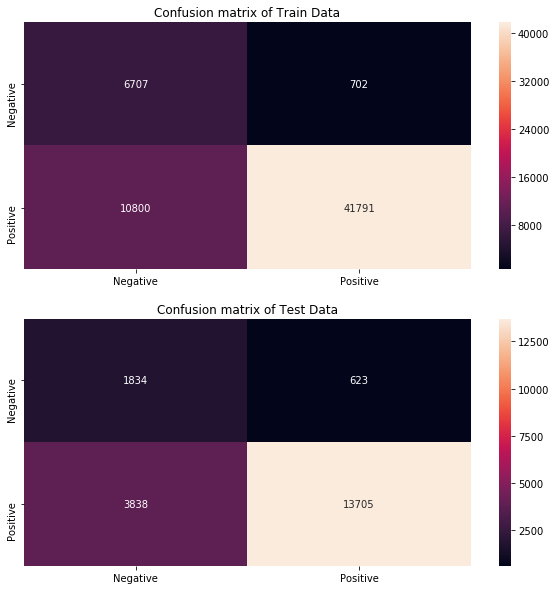

In [257]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (depth = 50 , min_samples_split=100) on model, we get auc score of future unseen data is 0.83

#####  Model Observations

In [258]:
y = PrettyTable()

y.field_names = ["Vectorizer","Model", "Max_Depth", "Min_samples_split", "AUC"]

y.add_row(["TFIDF W2V","Decision Tree",50,100,0.83])

print(y)

+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.83 |
+------------+---------------+-----------+-------------------+------+


#### 9.2 Adding Review Text length as a feature with Review and Summary Text vector

In [259]:
# Lengh of the Words in Each Review document

a=[]
for i in preprocessed_text_data:
    a.append(len(i.split()))

In [260]:
# Adding Length as a new Feature in DataFrame

filter_data["Length"]=a

##### 9.2.1Column Standardization using Standardization Formula:

* $\ (Xi-mean)/std $

In [261]:
mean1=filter_data.Length.mean()
std1=filter_data.Length.std()

In [262]:
b=a
c=[]
for i in b:
    stand=(i-mean1)/std1
    c.append(abs(stand))

In [263]:
filter_data.Length=c

##### 9.2.2. Data Splitting

In [264]:
# we took the sample data size as 100k 

final_data=filter_data[:100000]
final_data.shape

(100000, 11)

In [265]:
X=final_data.Length
Y=final_data.Score

In [266]:
x_1,x_test_3,y_1,y_test_3=train_test_split(X,Y,test_size=0.2,random_state=40)
x_train_3,x_cv_3,y_train_3,y_cv_3=train_test_split(x_1,y_1,test_size=0.25,random_state=40)
print(" Train data Size")
print(x_train_3.shape,y_train_3.shape)

print("cv data size")
print(x_cv_3.shape,y_cv_3.shape)
print("Test data size")
print(x_test_3.shape,y_test_3.shape)

 Train data Size
(60000,) (60000,)
cv data size
(20000,) (20000,)
Test data size
(20000,) (20000,)


##### 9.2.3 Horizontally stacking

##### Feature Engineering on TFIDF-W2V

In [267]:
# hstack takes list of list values. so we convert list to list of list

# For BOW
a_train=[]
for i in x_train_3.values:
    b=[]
    b.append(i)
    a_train.append(b)
    
a_cv=[]
for i in x_cv_3.values:
    b=[]
    b.append(i)
    a_cv.append(b)
    
a_test=[]
for i in x_test_3.values:
    b=[]
    b.append(i)
    a_test.append(b)

In [268]:
# For Training Data
tfidf_w2v_train_fe_im1=np.hstack((tfidf_w2v_train_fe_im,a_train))


# For cv Data

tfidf_w2v_cv_fe_im1=np.hstack((tfidf_w2v_cv_fe_im,a_cv))


# For test Data

tfidf_w2v_test_fe_im1=np.hstack((tfidf_w2v_test_fe_im,a_test))

In [269]:
tfidf_w2v_train_fe_im1.shape

(60000, 101)

##### 9.2.4 Feature engineering on Decision Tree (TFIDF W2V)

In [271]:
depth=[1,5,10,50,100,500,1000]
sample=[2,5,10,50,100,500,1000]

In [272]:
# Hyperparameter tuning

auc_train,auc_cv=Decision_Tree(depth=depth,split_sample=sample,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train, \
                                             cv_vector=tfidf_w2v_cv_fe_im1,cv_label=y_cv)

7it [01:14, 10.77s/it]


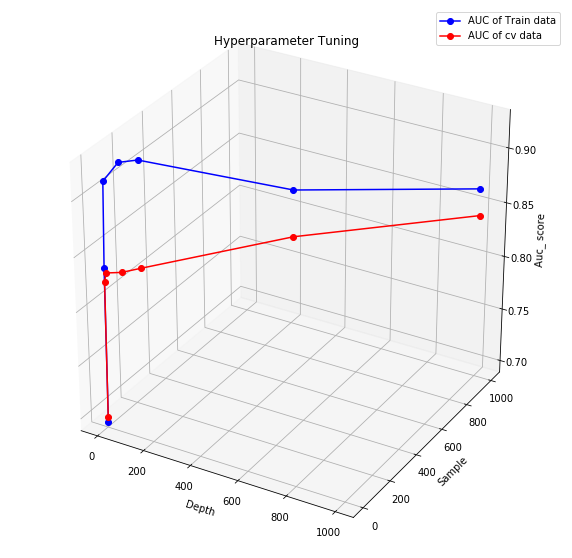

In [273]:
# auc_score plotting

auc_score(depth=depth,sample=sample,auc_train=auc_train,auc_cv=auc_cv)

##### Observation:

* To avoid overfitting and underfitting,choose (depth=50,sample=100), we get auc_score=0.82

In [276]:
# Apply best hyperparameter

train_proba,test_proba,fpr_train,tpr_train,fpr_test,tpr_test,auc_train,auc_test,\
=best_DT(best_depth=50,best_split=100,train_vector=tfidf_w2v_train_fe_im1,train_label=y_train_3,\
                               test_vector=tfidf_w2v_test_fe_im1,test_label=y_test_3)

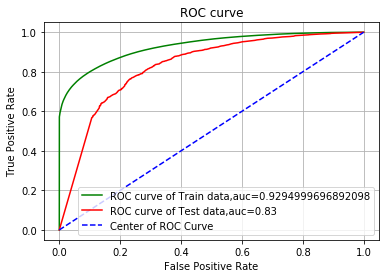

In [277]:
# References
# https://stackoverflow.com/questions/455612/limiting-floats-to-two-decimal-points

# plotting ROC graph

roc_model(fpr_train=fpr_train,tpr_train=tpr_train,fpr_test=fpr_test,tpr_test=tpr_test,\
         text1=str(auc_train),text2=str(round(auc_test,2)))

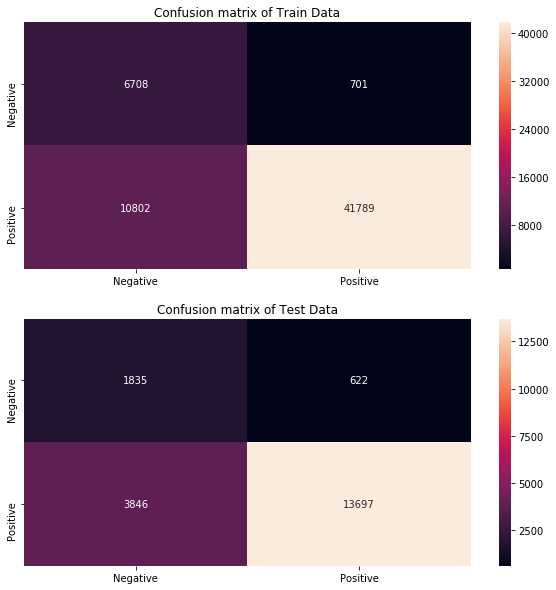

In [278]:
# confusion matrix

cm_plot(train_proba=train_proba,train_label=y_train,test_proba=test_proba,test_label=y_test)

##### Observation:

* When we applying best hyperparameter (depth = 50 , min_samples_split=100) on model, we get auc score of future unseen data is 0.83

#####  Model Observations

In [279]:
z = PrettyTable()

z.field_names = ["Vectorizer","Model", "Max_Depth", "Min_samples_split", "AUC"]

z.add_row(["TFIDF W2V","Decision Tree",50,100,0.83])

print(y)

+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.83 |
+------------+---------------+-----------+-------------------+------+


#### 9.3 Model Observations

In [280]:
print ("After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
print(y)
print(' ')
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
print(z)

After Applying Feature Engineering on Model
 
Feature Engineering( Review Text + Summary)
 
+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.83 |
+------------+---------------+-----------+-------------------+------+
 
Feature Engineering (Review Text + Summary + Length)
 
+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.83 |
+------------+---------------+-----------+-------------------+------+


* After applying Feature Engineering on the Decision Tree (TFIDF W2V), The Summary Text is used to improve the model performance. But the length does not make any impact on the model. So we just ignore the length feature. Therefore we will use Summary Text as a feature for further model performance improvement.

### 10. Conclusion

In [281]:
print ("1. Before Applying Feature Engineering on Model(Review Text)")
print(' ')
print(x)
print(' ')
print ("2. After Applying Feature Engineering on Model")
print(' ')
print("Feature Engineering( Review Text + Summary)")
print(' ')
print(y)
print("Feature Engineering (Review Text + Summary + Length)")
print(' ')
print(z)

1. Before Applying Feature Engineering on Model(Review Text)
 
+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
|    BOW     | Decision Tree |     50    |        100        | 0.82 |
|   TFIDF    | Decision Tree |     50    |        100        | 0.81 |
|  Avg W2V   | Decision Tree |     50    |        100        | 0.8  |
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.77 |
+------------+---------------+-----------+-------------------+------+
 
2. After Applying Feature Engineering on Model
 
Feature Engineering( Review Text + Summary)
 
+------------+---------------+-----------+-------------------+------+
| Vectorizer |     Model     | Max_Depth | Min_samples_split | AUC  |
+------------+---------------+-----------+-------------------+------+
| TFIDF W2V  | Decision Tree |     50    |        100        | 0.83 |


##### Data Cleaning ,Preprocessing and splitting:

* In the Data Cleaning process, we clean the duplicate datapoints and unconditioning data points. After the data cleaning process we get 364171 data points and sort based on timestamp.
* Then select the Review Text Feature as a important feature, then do data preprocessing on all the data points.
* Then select top 100k sample data points for further process. and then split the 100k data points using simple cross validation technique. Train= 60000, CV=20000, Test=20000.

##### Featurization:

* Then apply the data points on BOW,TFIDF,Avg W2V and TFIDF W2V for converting text to vector.

#####  Decision Tree Model: 

* Then apply these featurization vector on Decision Tree model . There are two hyperparameter one is depth and another one is     minimum samples for splitting the tree.
* Decision tree model (BoW) gives better result compared to other vectorizers.

##### Graph visualization:

* The BoW and Tfidf models decision trees were visualized by using graphviz tool.

##### Feature Importance:

* Then took the top 20 important features both BOW and TFIDF.

##### Feature Engineering:

* we took TFIDF- W2V for feature engineering, because its result is less compared to other vectors.
* We will apply feature engineering for improve the Decision Tree Model performance. For consider Summary and Review Text Length as a feature.
* After applying Feature Engineering on the Decision Tree Model, The Summary Text feature is improve model performance. But the length does not make any impact on the model. So we just ignore the length feature for future improvement.
* We consider the Summary Text feature for further Model performance improvement.